In [1]:
import numpy as np
from matplotlib import pyplot as plt
# from scipy.stats import multivariate_normal
from scipy.ndimage import gaussian_filter
from ipywidgets import interact, interactive, HBox, VBox, Layout
from IPython.display import display
import itertools

%matplotlib widget

In [2]:
def gabor_filter(
    X,
    Y,
    # # Parameters (replace with extracted values from your data)
    A=1.0,  # Amplitude
    sigma_x=1.0,  # Gaussian envelope width along x
    sigma_y=1.0,  # Gaussian envelope width along y
    gamma=1.0,
    f=0.5,  # Spatial frequency
    theta=np.pi / 4,  # Preferred orientation (radians)
    phi_0=np.pi / 3,  # Preferred phase (radians)
    theta_gauss=np.pi / 4.0,
):

    # Rotate coordinates
    x_prime = X * np.cos(theta) + Y * np.sin(theta)
    y_prime = -X * np.sin(theta) + Y * np.cos(theta)

    # print(f"{theta=}, {theta_gauss=}")
    if theta_gauss:
        x_prime_gauss = x_prime * np.cos(theta_gauss) + y_prime * np.sin(theta_gauss)
        y_prime_gauss = -x_prime * np.sin(theta_gauss) + y_prime * np.cos(theta_gauss)
    else:
        x_prime_gauss = x_prime
        y_prime_gauss = y_prime

    # Gabor function
    return (
        A
        * np.exp(
            -(
                x_prime_gauss**2 / (2 * sigma_x**2)
                + gamma**2 * y_prime_gauss**2 / (2 * sigma_y**2)
            )
        )
        * np.cos(2 * np.pi * f * x_prime + phi_0)
    )


def sine_grating(X, Y, theta, f, phi_0, square=False):
    # Rotate coordinates
    x_prime = X * np.cos(theta) + Y * np.sin(theta)

    # Gabor function
    if square:
        return np.sign(np.cos(2 * np.pi * f * x_prime + phi_0))
    else:
        return np.cos(2 * np.pi * f * x_prime + phi_0)


def output_nonlinearity(V, alpha, gamma, delta):
    return alpha * np.log(1 + np.exp((V - gamma) / alpha)) + delta

interactive(children=(FloatSlider(value=30.0, description='theta', max=180.0, step=10.0), FloatSlider(value=0.…

interactive(children=(FloatSlider(value=0.0, description='theta', max=180.0, step=1.0), FloatSlider(value=0.0,…

/tmp/ipykernel_57041/1367885277.py:303: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


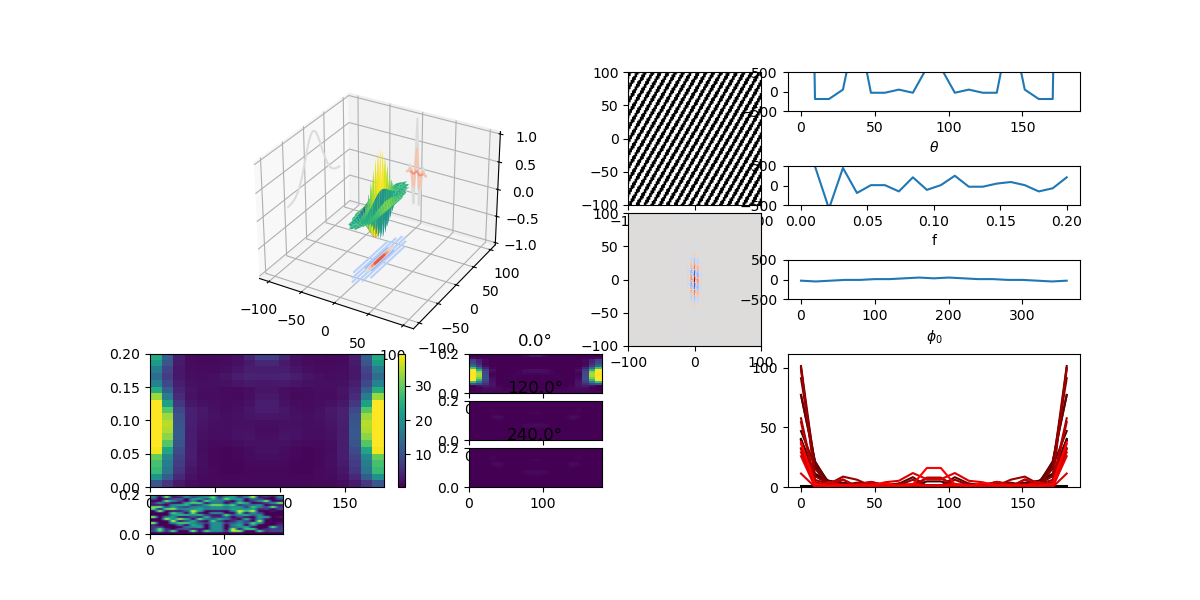

In [5]:
steps_FoV = 101

stimulus_range = [-100, 100]
X_FoV, Y_FoV = np.meshgrid(
    np.linspace(stimulus_range[0], stimulus_range[1], steps_FoV),
    np.linspace(stimulus_range[0], stimulus_range[1], steps_FoV),
)

plt.close("all")
with plt.ioff():
    # fig, ax = plt.subplots(1,1)
    fig = plt.figure(figsize=(12, 6))

gs = fig.add_gridspec(10, 6)

ax_filter = fig.add_subplot(gs[:6, :3], projection="3d")
ax_grating = fig.add_subplot(gs[:3, 3])
ax_combined = fig.add_subplot(gs[3:6, 3])

axx = {
    "theta": fig.add_subplot(gs[0, 4:]),
    "f": fig.add_subplot(gs[2, 4:]),
    "phi_0": fig.add_subplot(gs[4, 4:]),
}
ax_optimal_response = fig.add_subplot(gs[6:9, :2])
ax_responses = fig.add_subplot(gs[6:9, 4:])
ax_optimal_phase = fig.add_subplot(gs[9, 0])

ax_response_at_phi = []
for i in range(3):
    ax_response_at_phi.append(fig.add_subplot(gs[6 + i, 2]))


grating = sine_grating(X_FoV, Y_FoV, 20.0, 0.5, 0.0, square=True)
img_grating = ax_grating.imshow(
    grating,
    extent=[stimulus_range[0], stimulus_range[1], stimulus_range[0], stimulus_range[1]],
    cmap="gray",
)

G = gabor_filter(
    X_FoV, Y_FoV, A=1, sigma_x=1.0, sigma_y=1.0, f=0.5, theta=20.0 * np.pi / 180
)
# img_filter = ax_filter.imshow(
#     G, extent=[-5, 5, -5, 5], cmap="gray", clim=[-1, 1]
# )  # , levels=50, cmap="RdBu_r")
img_filter = ax_filter.plot_surface(X_FoV, Y_FoV, G)
ax_filter.set_zlim([-1, 1])

img_combined = ax_combined.imshow(
    G * grating,
    extent=[stimulus_range[0], stimulus_range[1], stimulus_range[0], stimulus_range[1]],
    cmap="coolwarm",
    clim=[-1, 1],
)  # , levels=50, cmap="RdBu_r")


axx["theta"].set_xlabel("$\\theta$")
axx["f"].set_xlabel("f")
axx["phi_0"].set_xlabel("$\phi_0$")


steps = {
    "theta": 20,
    "f": 20,
    "phi_0": 19,
}
arrays = {
    "theta": np.linspace(0, 180, steps["theta"]),
    "f": np.linspace(0, 0.2, steps["f"]),
    "phi_0": np.linspace(0, 360, steps["phi_0"]),
}

responses = {
    "theta": np.zeros(steps["theta"]),
    "f": np.zeros(steps["f"]),
    "phi_0": np.zeros(steps["phi_0"]),
}

lines = {}
(lines["theta"],) = axx["theta"].plot(arrays["theta"], responses["theta"])
(lines["f"],) = axx["f"].plot(arrays["f"], responses["f"])
(lines["phi_0"],) = axx["phi_0"].plot(arrays["phi_0"], responses["phi_0"])

filter_interactive = interactive(lambda x: x, x=10)
grating_interactive = interactive(lambda x: x, x=10)


def update_grating(
    theta=30,
    f=0.1,
    phi_0=0,
    square=True,
):

    grating = sine_grating(
        X_FoV, Y_FoV, theta * np.pi / 180, f, phi_0 * np.pi / 180, square=square
    )
    img_grating.set_data(grating)

    G = filter_interactive.result

    ## for different gratings, calculate overall response (sum)
    for key in ["theta", "f", "phi_0"]:

        params = {
            "theta": theta,
            "f": f,
            "phi_0": phi_0,
        }

        for i, value in enumerate(arrays[key]):
            params[key] = value
            grating_ = sine_grating(
                X_FoV,
                Y_FoV,
                params["theta"] * np.pi / 180,
                params["f"],
                params["phi_0"] * np.pi / 180,
                square=square,
            )
            responses[key][i] = (G * grating_).sum()
        lines[key].set_ydata(responses[key])

    # min = np.min([response_theta.min(), response_f.min(), response_phi.min()]) * 1.1
    # max = np.max([response_theta.max(), response_f.max(), response_phi.max()]) * 1.1
    for ax in axx.values():
        # ax.set_ylim([min,max])
        ax.set_ylim([-500, 500])

    update_combined(G, grating)

    return grating


# steps_phi = 19
# array_phi = np.linspace(0,360,steps_phi)


img_optimal_phase = ax_optimal_phase.imshow(
    np.random.rand(steps["theta"], steps["f"]),
    extent=[0, arrays["theta"].max(), 0, arrays["f"].max()],
    origin="lower",
    aspect="auto",
    cmap="viridis",
    clim=[0, 360],
)

img_optimal_response = ax_optimal_response.imshow(
    np.random.rand(steps["theta"], steps["f"]),
    extent=[0, arrays["theta"].max(), 0, arrays["f"].max()],
    origin="lower",
    aspect="auto",
    cmap="viridis",
)
plt.colorbar(img_optimal_response)

img_response_at_phi = []
for i in range(3):
    img_response_at_phi.append(
        ax_response_at_phi[i].imshow(
            np.random.rand(steps["theta"], steps["f"]),
            extent=[0, arrays["theta"].max(), 0, arrays["f"].max()],
            origin="lower",
            aspect="auto",
            cmap="viridis",
        )
    )
    ax_response_at_phi[i].set_title(f"{arrays['phi_0'][i * (steps['phi_0'] // 3)]}°")
    # plt.colorbar(img_optimal_response)

response_lines = []
for i in range(steps["f"]):
    (line,) = ax_responses.plot(
        arrays["theta"], np.zeros(steps["theta"]), color=[(i + 1) / steps["f"], 0, 0]
    )
    response_lines.append(line)


Theta, F = np.meshgrid(arrays["theta"], arrays["f"])


gratings = np.zeros((steps["phi_0"], steps["theta"], steps["f"], steps_FoV, steps_FoV))

for prod in itertools.product(
    enumerate(arrays["phi_0"]), enumerate(arrays["theta"]), enumerate(arrays["f"])
):
    idx, elems = zip(*prod)
    phi_0, theta, f = elems

    gratings[*idx] = sine_grating(
        X_FoV, Y_FoV, theta * np.pi / 180, f, phi_0 * np.pi / 180, square=True
    )


def update_filter(
    theta=0,
    theta_gauss=0,
    f=0.1,
    sigma_x=5.0,
    sigma_y=20.0,
    gamma=1.0,
    phi_0=0.0,
    update_phase=True,
):

    G = gabor_filter(
        X_FoV,
        Y_FoV,
        A=1,
        theta=theta * np.pi / 180,
        theta_gauss=theta_gauss * np.pi / 180,
        f=f,
        sigma_x=sigma_x,
        sigma_y=sigma_y,
        gamma=gamma,
        phi_0=phi_0 * np.pi / 180,
    )

    ax_filter.clear()

    G_plot = np.copy(G)
    G_plot[np.abs(G) < G.max() * 0.001] = np.nan
    ax_filter.plot_surface(X_FoV, Y_FoV, G_plot, cmap="viridis")
    ax_filter.contour(X_FoV, Y_FoV, G_plot, zdir="z", offset=-1, cmap="coolwarm")
    ax_filter.contour(
        X_FoV, Y_FoV, G_plot, zdir="x", offset=X_FoV.min(), cmap="coolwarm"
    )
    ax_filter.contour(
        X_FoV, Y_FoV, G_plot, zdir="y", offset=Y_FoV.max(), cmap="coolwarm"
    )
    ax_filter.set_zlim([-1, 1])
    # img_filter.set_data(G)
    update_combined(G, grating_interactive.result)

    if update_phase:
        # calculate response for entire 3D-grid and find optimal phi_0 for each theta and f
        response = np.tensordot(G, gratings, axes=([0, 1], [3, 4]))
        response_fr = output_nonlinearity(response, 1, np.percentile(response, 10), 0)

        optimal_idx = np.argmax(response, axis=0)
        optimal_phi_0 = arrays["phi_0"][optimal_idx]
        optimal_response = np.max(response, axis=0)

        for i, line in enumerate(response_lines):
            line.set_ydata(optimal_response[:, i])
        ax_responses.set_ylim([0, optimal_response.max() * 1.1])

        img_optimal_phase.set_data(optimal_phi_0.T)
        img_optimal_response.set_data(gaussian_filter(optimal_response, (1, 1)).T)
        clims = np.percentile(optimal_response, [5, 95])
        img_optimal_response.set_clim(clims)

        for i, img in enumerate(img_response_at_phi):
            phase_idx = i * (steps["phi_0"] // 3)
            img.set_data(gaussian_filter(response[phase_idx, ...], (1, 1)).T)
            # img.set_data(gaussian_filter(response_fr[phase_idx, ...], (1, 1)).T)
            img.set_clim(clims)

    return G


def update_combined(G, grating):
    img_combined.set_data(G * grating)


grating_interactive = interactive(
    update_grating,
    theta=(0, arrays["theta"][-1], 10),
    f=(0, arrays["f"][-1], 0.01),
    phi_0=(0, 360, 10),
    square=True,
)

filter_interactive = interactive(
    update_filter,
    theta=(0, arrays["theta"][-1], 1),
    theta_gauss=(0, arrays["theta"][-1], 1),
    f=(0, arrays["f"][-1], 0.01),
    sigma_x=(0.1, 50, 0.1),
    sigma_y=(0.1, 50, 0.1),
    gamma=(0.1, 4, 0.1),
    phi_0=(0, 360, 10),
    update_phase=True,
)

display(grating_interactive)
display(filter_interactive)


# VBox(
#     [
#         HBox(
#             [grating_interactive, filter_interactive],
#             layout=Layout(width="100%", display="flex", align_items="center"),
#         ),
#         fig.canvas,
#     ],
#     layout=Layout(width="60%", display="flex", align_items="center"),
# )
# ax_responses.colorbar()

plt.tight_layout()
plt.show()

interactive(children=(FloatSlider(value=0.0, description='a', max=2.0, min=-2.0), FloatSlider(value=5.0, description='b', max=10.0), Output()), _dom_classes=('widget-interact',))


interactive(children=(FloatSlider(value=0.0, description='a', max=2.0, min=-2.0), FloatSlider(value=5.0, descr…

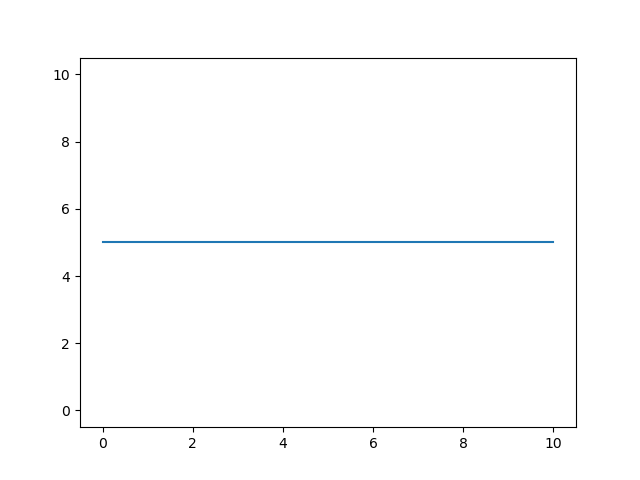

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)
steps = 21

x_arr = np.linspace(0, 10, steps)
(line,) = ax.plot(x_arr, np.linspace(0, 10, steps))


def test(a, b):
    # display(a * b)
    line.set_ydata(x_arr * a + b)
    print(theta_filter.result)
    return a * b


theta_filter = interactive(test, a=(-2, 2, 0.1), b=(0, 10, 0.1))
print(theta_filter)
display(theta_filter)

In [5]:
arrays

{'theta': array([  0.        ,   9.47368421,  18.94736842,  28.42105263,
         37.89473684,  47.36842105,  56.84210526,  66.31578947,
         75.78947368,  85.26315789,  94.73684211, 104.21052632,
        113.68421053, 123.15789474, 132.63157895, 142.10526316,
        151.57894737, 161.05263158, 170.52631579, 180.        ]),
 'f': array([0.        , 0.01052632, 0.02105263, 0.03157895, 0.04210526,
        0.05263158, 0.06315789, 0.07368421, 0.08421053, 0.09473684,
        0.10526316, 0.11578947, 0.12631579, 0.13684211, 0.14736842,
        0.15789474, 0.16842105, 0.17894737, 0.18947368, 0.2       ]),
 'phi_0': array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180., 200.,
        220., 240., 260., 280., 300., 320., 340., 360.])}